In [1]:
%pip install tensorflow

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,253,834 (12.41 MB)

 Trainable params: 3,251,018 (12.40 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 60s 57ms/step - accuracy: 0.3519 - loss: 2.0667 - val_accuracy: 0.4940 - val_loss: 1.5864 - learning_rate: 0.0010
Epoch 2/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5156 - loss: 1.2166

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5156 - loss: 1.2166 - val_accuracy: 0.4848 - val_loss: 1.6142 - learning_rate: 0.0010
Epoch 3/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.5828 - loss: 1.1699 - val_accuracy: 0.6139 - val_loss: 1.2259 - learning_rate: 0.0010
Epoch 4/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.7563 - val_accuracy: 0.6140 - val_loss: 1.2303 - learning_rate: 0.0010
Epoch 5/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.6634 - loss: 0.9502 - val_accuracy: 0.6827 - val_loss: 0.9188 - learning_rate: 0.0010
Epoch 6/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7031 - loss: 1.1586 - val_accuracy: 0.6860 - val_loss: 0.9069 - learning_rate: 0.0010
Epoch 7/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.7050 - loss: 0.8327 - val_accuracy: 0.7050 - val_loss: 0.9341 - learning_rate: 0.0010
Epoch 8/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8281 - loss: 0.5124 - val_a

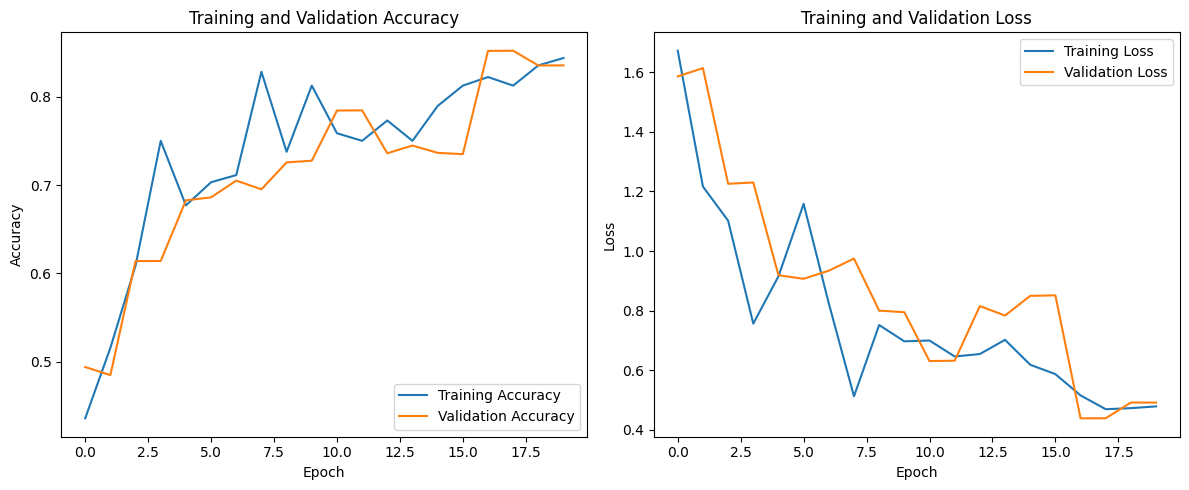


Model performance saved to model_accuracy.txt
Model Performance Summary (at best validation accuracy epoch):
Test Accuracy: 0.8518
Test Loss: 0.4384
Best Epoch: 18
Final Training Accuracy: 0.8125
Final Validation Accuracy: 0.8520
Final Training Loss: 0.4690
Final Validation Loss: 0.4387
Total Training Epochs Run: 20
Model Parameters: 3253834


In [ ]:
# CNN Classroom Exercise: Image Classification with CIFAR-10
# Objective: Maximize model accuracy using advanced techniques.
# Environment: Google Colab with GPU
# Dataset: CIFAR-10 (10 classes of 32x32 color images)

# Step 1: Import Libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Load and Preprocess CIFAR-10 Dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to range [0, 1]
train_images, test_images = train_images.astype('float32') / 255.0, test_images.astype('float32') / 255.0

# Define class names for visualization
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Step 3: Data Augmentation
# Create more training data from the existing images by applying random transformations.
# This helps the model generalize better and reduces overfitting.
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(train_images)

# Step 4: Build the Advanced CNN Model
# This model is deeper and wider, with Batch Normalization and Dropout for regularization.
model = models.Sequential([
    # Input Block
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.35),

    # Flatten the output for dense layers
    layers.Flatten(),

    # Dense Layers
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output Layer: 10 units (one per class) with softmax
    layers.Dense(10, activation='softmax')
])

# Display model summary
model.summary()

# Step 5: Compile the Model
# Using the Adam optimizer with a default learning rate. The learning rate will be
# adjusted during training by the ReduceLROnPlateau callback.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 6: Define Callbacks for Training
# Callbacks dynamically adjust training parameters for optimal performance.
# EarlyStopping: Stops training when validation loss stops improving to prevent overfitting.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20, # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored metric.
)

# ReduceLROnPlateau: Reduces learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.00001
)

callbacks = [early_stopping, reduce_lr]

# Step 7: Train the Model
# We train for a large number of epochs; EarlyStopping will find the optimal point.
# We use datagen.flow() to feed the augmented images to the model.
epochs = 10
batch_size = 64

history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=(test_images, test_labels),
    callbacks=callbacks
)


# Step 8: Evaluate the Model
# The model has already been restored to its best weights by the EarlyStopping callback.
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")

# Step 9: Plot Training and Validation Curves
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Step 10: Save Model Performance for Autograding
# This cell saves the final model performance to a text file.
try:
    # Find the epoch with the best validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])
    final_train_acc = history.history['accuracy'][best_epoch]
    final_val_acc = history.history['val_accuracy'][best_epoch]
    final_train_loss = history.history['loss'][best_epoch]
    final_val_loss = history.history['val_loss'][best_epoch]

    # Create performance summary
    performance_text = f"""Model Performance Summary (at best validation accuracy epoch):
Test Accuracy: {test_acc:.4f}
Test Loss: {test_loss:.4f}
Best Epoch: {best_epoch + 1}
Final Training Accuracy: {final_train_acc:.4f}
Final Validation Accuracy: {final_val_acc:.4f}
Final Training Loss: {final_train_loss:.4f}
Final Validation Loss: {final_val_loss:.4f}
Total Training Epochs Run: {len(history.history['accuracy'])}
Model Parameters: {model.count_params()}"""

    # Save to file
    with open('model_accuracy.txt', 'w') as f:
        f.write(performance_text)

    print("\nModel performance saved to model_accuracy.txt")
    print(performance_text)

except Exception as e:
    print(f"Error saving model performance: {e}")
    with open('model_accuracy.txt', 'w') as f:
        f.write(f"Model execution completed with errors: {e}")